In [5]:
from keras.models import Model
from keras.layers import Flatten, Conv2D, Conv2DTranspose, Dense, Input, Reshape, Cropping2D, concatenate
from keras.utils import plot_model
import keras

(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_train = x_train.astype('float32') / 255.

x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
x_test = x_test.astype('float32') / 255.

# # encoder
# enc_input = Input(shape=(28,28,1), name='enc_input')
# x = Conv2D(filters=32, kernel_size=(3,3), strides=(2,2), activation='relu', padding='same', name='conv1')(enc_input)
# x = Conv2D(filters=64, kernel_size=(3,3), strides=(2,2), activation='relu', padding='same', name='conv2')(x)
# # x = Conv2D(filters=1, kernel_size=(3,3), strides=(2,2), activation='sigmoid', padding='same')(x)
# x = Conv2D(filters=1, kernel_size=(4,4), strides=(1,1), activation='sigmoid', padding='valid')(x)
# latent = Flatten(name='flatten')(x)

# # decoder
# dec_input = Input(shape=(16,), name='dec_input')
# x = Reshape(target_shape=(4,4,1))(dec_input)
# x = Conv2DTranspose(filters=1, kernel_size=(4,4), strides=(1,1), activation='relu', padding='valid')(x)
# x = Conv2DTranspose(filters=64, kernel_size=(3,3), strides=(2,2), activation='relu', padding='same', name='deconv1')(x)
# x = Conv2DTranspose(filters=32, kernel_size=(3,3), strides=(2,2), activation='relu', padding='same', name='deconv2')(x)
# # x = Conv2DTranspose(filters=1, kernel_size=(3,3), strides=(2,2), padding='same', name='pt_conv')(x)
# dec_output = Conv2DTranspose(filters=1, kernel_size=(3,3), strides=(1,1), padding='same', name='pt_conv')(x)
# # dec_output = Cropping2D(cropping=((2,2),(2,2)))(x)

# encoder = Model(enc_input, latent, name="Encoder")
# decoder = Model(dec_input, dec_output, name="Decoder")
# model = Model(encoder.input, decoder(encoder.output))

# print(model.summary())

In [21]:
model.compile(loss='mse', optimizer='adam')
model.fit(x_train, x_train, validation_data=(x_test, x_test), epochs=25, batch_size=32)

Epoch 1/25
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0514 - val_loss: 0.0435
Epoch 2/25
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0414 - val_loss: 0.0397
Epoch 3/25
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0392 - val_loss: 0.0382
Epoch 4/25
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0380 - val_loss: 0.0371
Epoch 5/25
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0372 - val_loss: 0.0363
Epoch 6/25
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0364 - val_loss: 0.0356
Epoch 7/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0357 - val_loss: 0.0353
Epoch 8/25
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0350 - val_loss: 0.0343
Epoch 9/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0344 - val_loss: 0.0337
Epoch 10/25
1875/1875 [==============================] - 8s 4ms/step - loss: 0.034

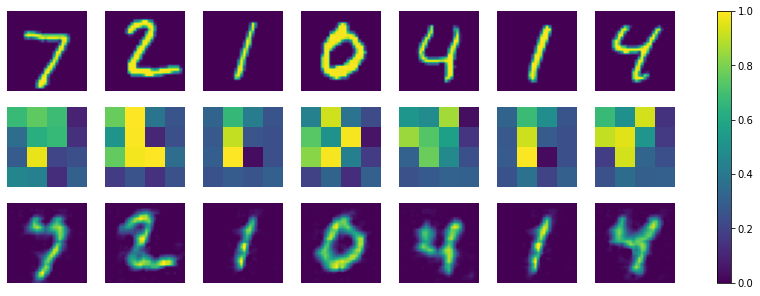

In [6]:
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

model = keras.models.load_model('../models/FCAE.h5')
# model.summary()
latent = keras.models.Model(model.inputs, model.get_layer('flatten').output)
n = 7
plt.figure(figsize=(15, 5))
axs = []
for i in range(n):
    
    # predict
    x = x_test[i]
    z = latent(x.reshape(1,28,28,1))
    y = model(x.reshape(1,28,28,1))
    
    axs.append(plt.subplot(3, n, i+1))
    plt.axis('off')
    plt.imshow(x.reshape(28,28), vmin=0, vmax=1)
    
    axs.append(plt.subplot(3, n, n+i+1))
    plt.axis('off')
    plt.imshow(tf.reshape(z, (4,4)), vmin=0, vmax=1)
    
    axs.append(plt.subplot(3, n, 2*n+i+1))
    plt.axis('off')
    plt.imshow(tf.reshape(y, (28,28)), vmin=0, vmax=1)
plt.colorbar(ax=axs)

In [34]:
from keras.models import Model
from keras.layers import Flatten, Conv2D, Conv2DTranspose, Dense, Input, Reshape, Cropping2D, MaxPooling2D
from keras.utils import plot_model
import keras

import keras, math
import numpy as np

# DATASET

class dataGen(keras.utils.Sequence):
    def __init__(self, xs, batch_size=32):
        self.batch_size=batch_size
        self.xs = xs
        self.on_epoch_end()
    def __len__(self):
        return math.ceil(len(self.xs)/self.batch_size)
    def split(self, im, nrows=14, ncols=14):
        r, h = im.shape[:-1] # exclude channel dim
        return (im.reshape(h//nrows,nrows,-1,ncols).swapaxes(1,2).reshape(-1,nrows,ncols,1))
    def __getitem__(self, i): 
        batch = self.xs[i*self.batch_size:(i+1)*self.batch_size]
        x1s, x2s, x3s, x4s = [], [], [], []
        for x in batch:
            x1, x2, x3, x4 = self.split(x)
            x1s.append(x1)
            x2s.append(x2)
            x3s.append(x3)
            x4s.append(x4)
        xs = [np.array(x1s), np.array(x2s), np.array(x3s), np.array(x4s)]
        return xs, batch
    def on_epoch_end(self):
        self.xs = np.random.permutation(self.xs)

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_train = x_train.astype('float32') / 255.
train_data = dataGen(x_train)

x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
x_test = x_test.astype('float32') / 255.
test_data = dataGen(x_test)


# shared layers
enc_inputs = [Input(shape=(14,14,1)) for _ in range(4)]
conv1 = Conv2D(filters=32, kernel_size=(3,3), strides=(2,2), activation='relu', padding='same')
conv2 = Conv2D(filters=64, kernel_size=(3,3), strides=(2,2), activation='relu', padding='same')
# conv3 = Conv2D(filters=1, kernel_size=(3,3), strides=(2,2), activation='sigmoid', padding='same')
conv3 = Conv2D(filters=1, kernel_size=(3,3), strides=(1,1), activation='sigmoid', padding='valid')
latent = Flatten()

# encoder
latents = []
for i in range(4):
    enc_out = latent(conv3(conv2(conv1(enc_inputs[i]))))
    latents.append(enc_out)
latent_concat = keras.layers.concatenate(latents, name='latent_concat')

# decoder
dec_input = Input(shape=(16,), name='dec_input')
x = Reshape(target_shape=(4,4,1))(dec_input)
x = Conv2DTranspose(filters=1, kernel_size=(4,4), strides=(1,1), activation='relu', padding='valid')(x)
x = Conv2DTranspose(filters=64, kernel_size=3, strides=2, activation='relu', padding='same', name='deconv1')(x)
x = Conv2DTranspose(filters=32, kernel_size=3, strides=2, activation='relu', padding='same', name='deconv2')(x)
dec_output = Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding='same', name='pt_conv')(x)
# dec_output = Cropping2D(cropping=((2,2),(2,2)))(x)

encoders = [Model(enc_inputs[i], latents[i], name='Encoder_%d'%i) for i in range(4)]
decoder = Model(dec_input, dec_output, name="Decoder")
model = Model(enc_inputs, decoder(latent_concat))

print(model.summary())

Model: "model_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_49 (InputLayer)           [(None, 14, 14, 1)]  0                                            
__________________________________________________________________________________________________
input_50 (InputLayer)           [(None, 14, 14, 1)]  0                                            
__________________________________________________________________________________________________
input_51 (InputLayer)           [(None, 14, 14, 1)]  0                                            
__________________________________________________________________________________________________
input_52 (InputLayer)           [(None, 14, 14, 1)]  0                                            
___________________________________________________________________________________________

In [35]:
model.compile(loss='mse', optimizer='adam')
model.fit(train_data, validation_data=(test_data), epochs=25, batch_size=32)

Epoch 1/25
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0526 - val_loss: 0.0457
Epoch 2/25
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0446 - val_loss: 0.0438
Epoch 3/25
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0426 - val_loss: 0.0416
Epoch 4/25
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0414 - val_loss: 0.0405
Epoch 5/25
1875/1875 [==============================] - 12s 7ms/step - loss: 0.0406 - val_loss: 0.0398
Epoch 6/25
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0399 - val_loss: 0.0392
Epoch 7/25
1875/1875 [==============================] - 14s 8ms/step - loss: 0.0394 - val_loss: 0.0390
Epoch 8/25
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0390 - val_loss: 0.0384
Epoch 9/25
1875/1875 [==============================] - 12s 7ms/step - loss: 0.0386 - val_loss: 0.0381
Epoch 10/25
1875/1875 [==============================] - 11s 6ms/step - l

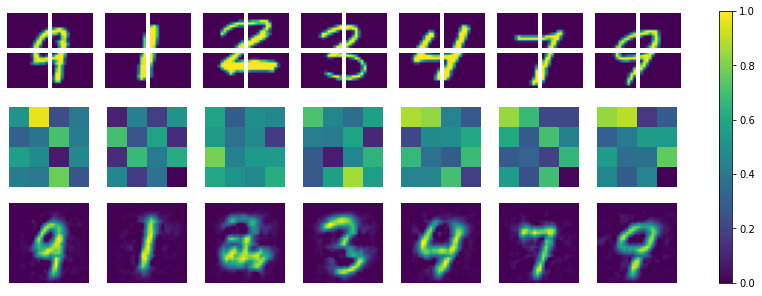

In [30]:
import matplotlib.pyplot as plt
import tensorflow as tf

n = 7
# n = 1
plt.figure(figsize=(15, 5))
axs = []
for (xs, ys), i in zip(test_data, range(n)):
#     axs.append(plt.subplot(3, n, i+1))
    ax = plt.subplot(3, n, i+1)
    for j in range(4):
        r = int(j/2)
        c = j%2
        ins = ax.inset_axes([c*0.55,0.5-r*0.5,0.5,0.5])
        ins.axis('off')
        ins.imshow(xs[j][0], vmin=0, vmax=1)
    ax.axis('off')
    axs.append(ax)
        
    z = [encoder(x[0].reshape(1,14,14,1)) for encoder, x in zip(encoders, xs)]
    a = np.empty((4,4))
    for j in range(4):
        r = int(j/2)
        c = j%2
        a[r*2:(r+1)*2, c*2:(c+1)*2] = tf.reshape(z[j], (2,2))
    axs.append(plt.subplot(3, n, n+i+1))
    plt.axis('off')
    plt.imshow(a, vmin=0, vmax=1)
    
    y = model.predict(xs)
    axs.append(plt.subplot(3, n, 2*n+i+1))
    plt.axis('off')
    plt.imshow(tf.reshape(y[0], (28,28)), vmin=0, vmax=1)
plt.colorbar(ax=axs)
plt.savefig('../img/58_PLOTS/F4S_sharedWeights_expl.png',  bbox_inches='tight', transparent=True, pad_inches=0)

In [9]:
from keras.layers import Flatten, Conv2D, Conv2DTranspose, Dense, Input, Reshape, concatenate, Activation, Dropout, MaxPooling2D, Cropping2D
from keras import Sequential
from keras.models import Model

import tensorflow as tf
import keras
import sys; sys.path.insert(0, '..')
import utils

(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_train = x_train.astype('float32') / 255.
x_train_split = np.array([utils.split(x, 14, 14) for x in x_train], dtype='float32')

x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
x_test = x_test.astype('float32') / 255.
x_test_split = np.array([utils.split(x, 14, 14) for x in x_test], dtype='float32')

class MultiSplit(Model):
    def __init__(self, n_splits, latent_dim, input_shape, output_shape):
        super(MultiSplit, self).__init__()
        self.encoder = self._create_encoder(latent_dim, input_shape)
        self.input_reshaper = utils.Reshaper((n_splits, *input_shape), input_shape)
        self.latent_reshaper = utils.Reshaper([latent_dim], [n_splits * latent_dim])
        self.decoder = self._create_decoder(n_splits * latent_dim, output_shape)
        
    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            y_pred = self(x)
            loss = self.compiled_loss(y, y_pred)
        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}
    
    def test_step(self, data):
        x, y = data
        y_pred = self(x, training=False)
        self.compiled_loss(y, y_pred)
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}
    
    def call(self, x, training=True):
        z = self.encode(x, training=training)
        y_reco = self.decode(z ,training=training)
        return y_reco
        
    def encode(self, x, training=True):
        return self.encoder( self.input_reshaper(x) , training)
    
    def decode(self, z, training=True):
        return self.decoder( self.latent_reshaper(z) , training)
    
    def _create_encoder(self, latent_dim, input_shape, n_filters=[32,64]):
        return Sequential([
            Input(shape=input_shape),
            Conv2D(filters=n_filters[0], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Conv2D(filters=n_filters[1], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Conv2D(filters=1, kernel_size=(3,3), strides=(2,2), activation='sigmoid', padding='same'),
            Flatten(),
        ], name='encoder')

    def _create_decoder(self, latent_dim, io_shape, n_filters=[32,64]):
        return Sequential([
            Input(shape=(latent_dim)),
            Reshape((4,4,1)),
            Conv2DTranspose(filters=n_filters[1], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Conv2DTranspose(filters=n_filters[0], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Conv2DTranspose(filters=1, kernel_size=(3,3), strides=(2,2), padding='same'),
            Cropping2D(cropping=((2,2), (2,2))),
            Activation('linear', name='decoder_out')
        ])
    
n_splits = 4
output_shape = (28, 28, 1)
input_shape  = (14, 14, 1)
split_x, split_y = 14, 14
latent_dim = 4

model = MultiSplit(n_splits, latent_dim, input_shape, output_shape)
print(model.encoder.summary())
print(model.decoder.summary())

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 7, 7, 32)          320       
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 4, 4, 64)          18496     
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 2, 2, 1)           577       
_________________________________________________________________
flatten_7 (Flatten)          (None, 4)                 0         
Total params: 19,393
Trainable params: 19,393
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_5 (Reshape)          (None, 4, 4, 1)           0         
____________________________

In [10]:
model.compile(loss='mse', optimizer='adam')
model.fit(x_train_split, x_train, validation_data=(x_test_split, x_test), epochs=25)

Epoch 1/25
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0603 - val_loss: 0.0535
Epoch 2/25
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0520 - val_loss: 0.0503
Epoch 3/25
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0494 - val_loss: 0.0482
Epoch 4/25
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0478 - val_loss: 0.0473
Epoch 5/25
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0468 - val_loss: 0.0464
Epoch 6/25
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0460 - val_loss: 0.0458
Epoch 7/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0454 - val_loss: 0.0450
Epoch 8/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0449 - val_loss: 0.0444
Epoch 9/25
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0444 - val_loss: 0.0441
Epoch 10/25
1875/1875 [==============================] - 6s 3ms/step - loss: 0.044